In [1]:
from collections import defaultdict, Counter
from scipy.sparse import csr_matrix

class MultiGraph:
    def __init__(self):
        self.n_nodes = 0
        self.n_rels = 0
        self.nodes = {}
        self.rels = {}
        self.node_labels = []
        self.rel_labels = []
        self.sparse_graph = {} #{relation: [row, col, data]}
        self.rel_counter = Counter()
    
    def add_connection(self, connection):
        # connection is (source, relation, target)
        src,rel,targ = connection
        #add new nodes and relations to dictionaries
        if src not in self.nodes.keys():
            self.nodes[src] = self.n_nodes
            self.node_labels.append(src)
            self.n_nodes += 1
        if targ not in self.nodes.keys():
            self.nodes[targ] = self.n_nodes
            self.node_labels.append(targ)
            self.n_nodes += 1
        if rel not in self.rels.keys():
            self.rels[rel] = self.n_rels
            self.rel_labels.append(rel)
            self.n_rels += 1
            self.sparse_graph[self.rels[rel]] = [[],[],[]] #{relation: [row, col, data]}
        #count number of relations
        self.rel_counter.update({rel: 1})
        # add new connection to graph
        self.sparse_graph[self.rels[rel]][0].append(self.nodes[src])
        self.sparse_graph[self.rels[rel]][1].append(self.nodes[targ])
        self.sparse_graph[self.rels[rel]][2].append(1)
    
    def get_adjacency_matrix(self):
        #iterleave all the columns from the individual adjacency matrices
        #it is an out-going adjacency graph
        full_matrix = [[],[],[]]
        for k in range(self.n_rels):
            full_matrix[0].extend(self.sparse_graph[k][0])
            #shift the column index to fit the added relation 
            col_shift = [i*self.n_rels+k for i in self.sparse_graph[k][1]]
            full_matrix[1].extend(col_shift)
            full_matrix[2].extend(self.sparse_graph[k][2])
        shape = (self.n_nodes,self.n_nodes*self.n_rels)
        return csr_matrix((full_matrix[2], (full_matrix[0],full_matrix[1])), shape=shape, dtype=np.float32)
    
    def get_adjacency_matrix_k(self,k):
        #it is an out-going adjacency graph of relation k
        graph_k = self.sparse_graph[self.rels[k]]
        shape = (self.n_nodes,self.n_nodes)
        return csr_matrix((graph_k[2], (graph_k[0],graph_k[1])), shape=shape, dtype=np.float32)
    
    def get_node_label(self,index):
        return self.node_labels[index]
    
    def get_relation_label(self,index):
        return self.rel_labels[index]
    
    def get_relation_counter(self):
        return self.counter

In [2]:
import unicodecsv as csv
""" EXAMPLE
add,IS,operator
subtract,IS,operator
multiply,IS,operator
divide,IS,operator
open_closure,IS,operator
close_closure,IS,operator
"""
op_graph = MultiGraph()
#with open('operator_graph.csv', 'r') as csvfile:
for i in range(45):
    print('loading relation '+str(i)+'...')
    with open('aifb_csv/aifb_relation_'+str(i)+'.csv', 'r') as csvfile:
        graphreader = csv.reader(csvfile, delimiter=",")
        for row in graphreader:
            #print(row)
            op_graph.add_connection(row)
    
# The AIFB dataset has 176 people and they are associated with one of four affiliations in the organization.
# The completeSet.tsv file gives the URIs of the people and their affiliation
# (number, person, affiliation)
person_dict = {}
with open('aifb_csv/completeDataset.tsv', 'r') as csvfile:
    graphreader = csv.reader(csvfile, delimiter="\t")
    i = 0
    for row in graphreader:
        if i == 0:
            i += 1
            continue
        person_dict[row[1]] = (row[1],row[2])

loading relation 0...
loading relation 1...
loading relation 2...
loading relation 3...
loading relation 4...
loading relation 5...
loading relation 6...
loading relation 7...
loading relation 8...
loading relation 9...
loading relation 10...
loading relation 11...
loading relation 12...
loading relation 13...
loading relation 14...
loading relation 15...
loading relation 16...
loading relation 17...
loading relation 18...
loading relation 19...
loading relation 20...
loading relation 21...
loading relation 22...
loading relation 23...
loading relation 24...
loading relation 25...
loading relation 26...
loading relation 27...
loading relation 28...
loading relation 29...
loading relation 30...
loading relation 31...
loading relation 32...
loading relation 33...
loading relation 34...
loading relation 35...
loading relation 36...
loading relation 37...
loading relation 38...
loading relation 39...
loading relation 40...
loading relation 41...
loading relation 42...
loading relation 43..

In [3]:
import keras
import numpy as np
from keras.models import Sequential, Model, model_from_json
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Activation
#load the saved embeddings
# load json and create model
json_file = open('coding_model.json', 'r')
model_json = json_file.read()
json_file.close()
model = model_from_json(model_json)
# load weights into new model
model.load_weights("coding_model.h5")
print("Loaded model from disk")

Using Theano backend.


Loaded model from disk


In [4]:
a_graph = op_graph.get_adjacency_matrix()

In [5]:
model.compile(optimizer='adam', loss='mse')
embedding = model.predict(a_graph)

In [6]:
person_embeddings = []
person_labels = []
for person in person_dict:
    person_embeddings.append(embedding[op_graph.nodes[person]])
    label = person_dict[person][1].rsplit('/',2)[-1]
    person_labels.append(label)
person_numbers = dict([(i,j) for j,i in enumerate(set(person_labels))])
labels = [person_numbers[x] for x in person_labels]

In [7]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import gensim


#from https://medium.com/@aneesha/using-tsne-to-plot-a-subset-of-similar-words-from-word2vec-bb8eeaea6229
def tsnescatterplot(vectors, vector_labels):
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(vectors)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    
    # display scatter plot
    plt.figure(figsize=(8,6),dpi=200)
    plt.scatter(x_coords, y_coords, c=vector_labels)
    

    #for label, x, y in zip(vector_labels, x_coords, y_coords):
    #    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

def pcascatterplot(vectors, vector_labels):
            
    # find tsne coords for 2 dimensions
    pca = PCA(n_components=2)
    np.set_printoptions(suppress=True)
    Y = pca.fit_transform(vectors)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.figure(figsize=(8,6),dpi=200)
    plt.scatter(x_coords, y_coords, c=vector_labels)
    

    #for label, x, y in zip(vector_labels, x_coords, y_coords):
    #    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

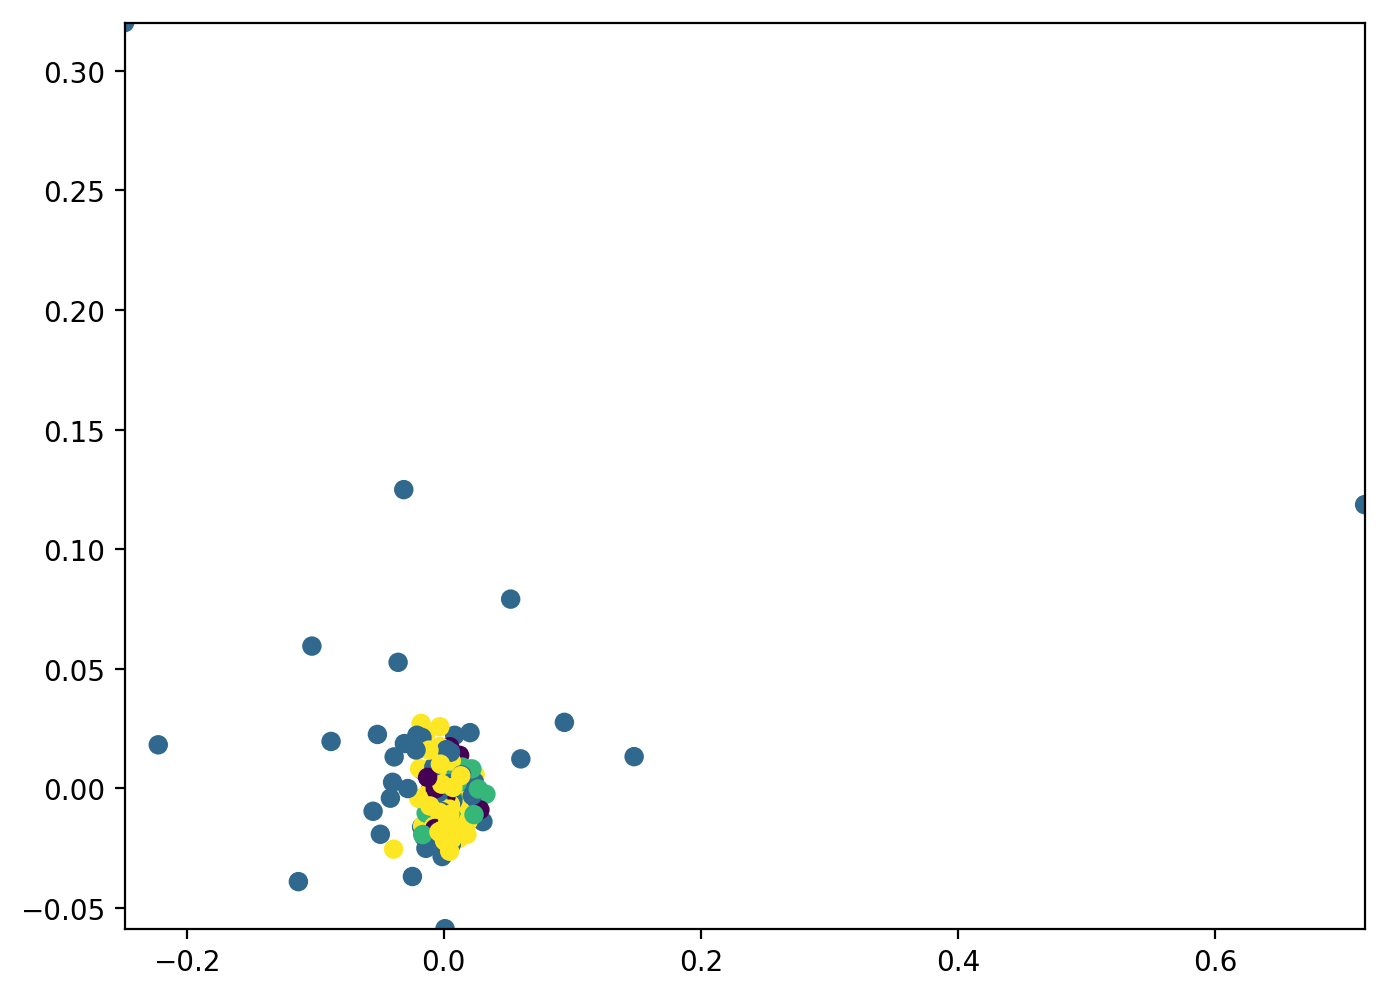

In [8]:
pcascatterplot(person_embeddings, labels)

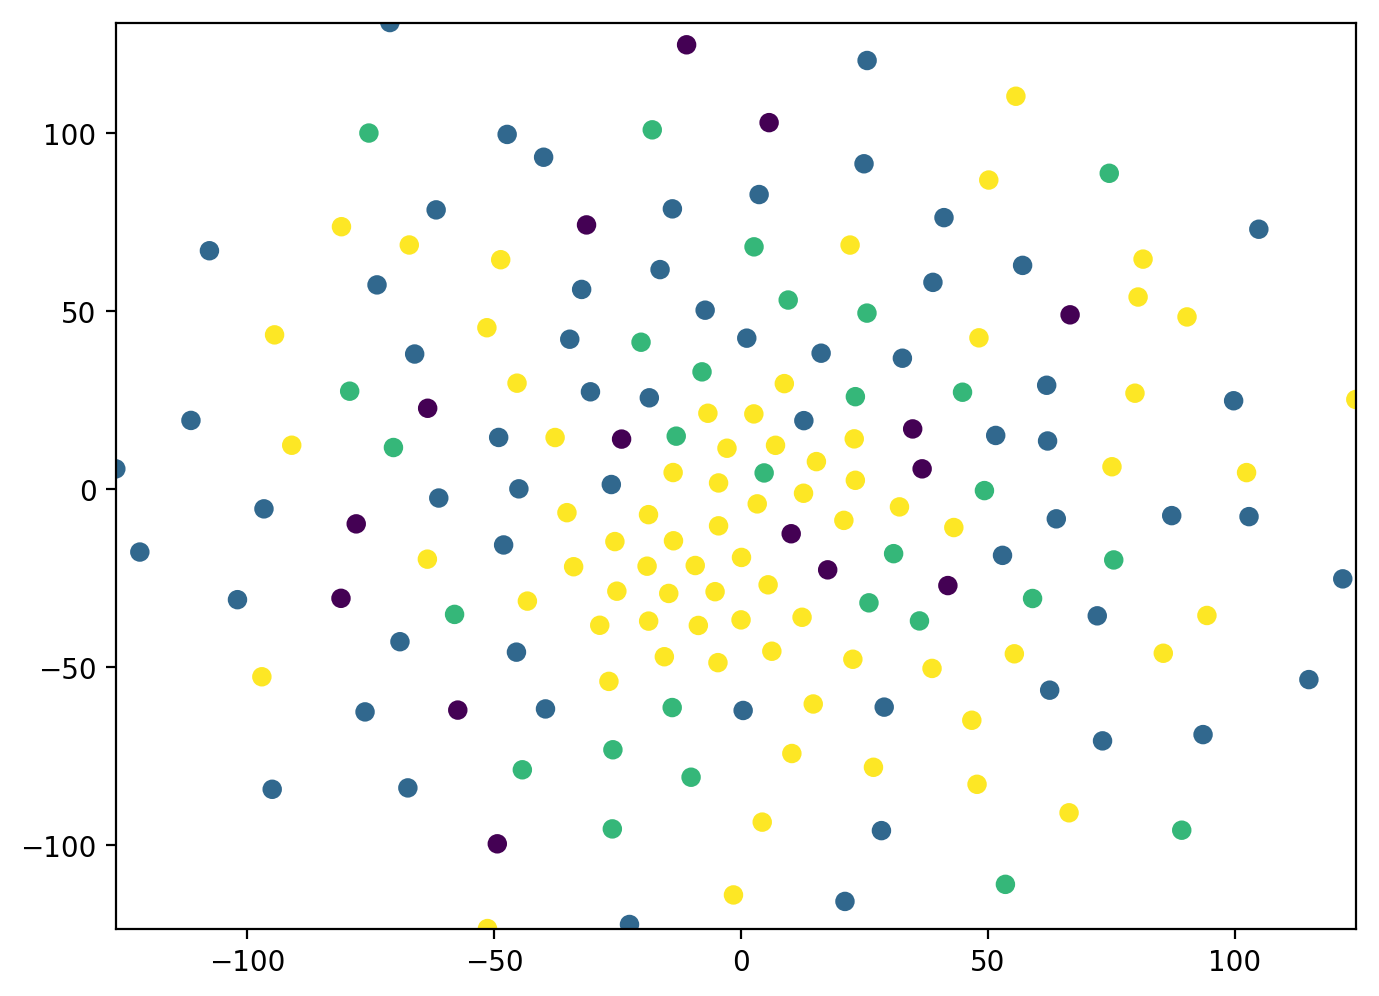

In [9]:
tsnescatterplot(person_embeddings, labels)